In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import math
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# This will only work is DataCleaningScript is in the same folder as the notebook you're running this chunk in
from UpdatedDataCleaningScript import cleanData

# This will load you in the cleaned data set
# It may take some time - the dataset is large
master = cleanData()

In [3]:
# i'd advise keeping a copy you can keep cloning from incase you make any changes to the master data and want the data to reset
# without having to run the cleaning process again
mastercopy = master.copy(deep = True)

In [4]:
# Following cells present for the purpose of data inspection

In [5]:
master.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue,DateAnswered,Confidence,GroupId,QuizId,...,Age,TimeSlot,WeeHours,EarlyMorning,MidMorning,Afternoon,Evening,Night,Overconfidence,Underconfidence
0,898,2111,280203,1,2,2,2019-12-08 17:47:00,NaN,95,86,...,12.0,Evening,False,False,False,False,True,False,0,0
1,359,2111,1177798,0,3,4,2020-03-12 15:30:00,NaN,95,115,...,12.0,Afternoon,False,False,False,True,False,False,0,0
2,920,2111,154427,1,1,1,2020-01-05 19:21:00,NaN,95,59,...,12.0,Evening,False,False,False,False,True,False,0,0
3,908,2111,362958,1,4,4,2019-11-25 20:19:00,NaN,95,109,...,12.0,Night,False,False,False,False,False,True,0,0
4,795,2111,566849,1,2,2,2019-11-25 20:21:00,NaN,95,109,...,12.0,Night,False,False,False,False,False,True,0,0


In [6]:
master.columns

Index(['QuestionId', 'UserId', 'AnswerId', 'IsCorrect', 'CorrectAnswer',
       'AnswerValue', 'DateAnswered', 'Confidence', 'GroupId', 'QuizId',
       'SchemeOfWorkId', 'Gender', 'DateOfBirth', 'PremiumPupil', 'IsAnswered',
       'TimeAnswered', 'HourAnswered', 'Age', 'TimeSlot', 'WeeHours',
       'EarlyMorning', 'MidMorning', 'Afternoon', 'Evening', 'Night',
       'Overconfidence', 'Underconfidence'],
      dtype='object')

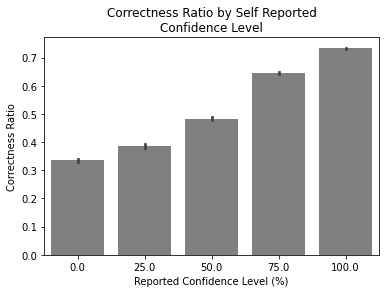

In [7]:
# Plot CorrectnessByConfidence figure
masterConf = master[pd.notnull(master['Confidence'])]
masterConfAgg = masterConf.groupby('Confidence').agg('mean')
sns.barplot(x='Confidence', y = 'IsCorrect', data =  masterConf, color = 'grey')
plt.title('Correctness Ratio by Self Reported\nConfidence Level')
plt.ylabel('Correctness Ratio')
plt.xlabel('Reported Confidence Level (%)')
plt.savefig('CorrectnessByConfidence')

In [8]:
ct = pd.crosstab(masterConf['TimeSlot'], masterConf['Confidence'],margins = True)
ct.div(ct["All"],axis=0)

Confidence,0.0,25.0,50.0,75.0,100.0,All
TimeSlot,,,,,,
Afternoon,0.084290,0.047973,0.143896,0.257458,0.466382,1.0
EarlyMorning,0.084013,0.056688,0.185717,0.258059,0.415524,1.0
Evening,0.080592,0.048873,0.150715,0.254070,0.465750,1.0
MidMorning,0.071801,0.049902,0.149809,0.248219,0.480269,1.0
Night,0.098487,0.056493,0.172151,0.250471,0.422399,1.0
WeeHours,0.146212,0.072727,0.184091,0.211364,0.385606,1.0
All,0.082941,0.050241,0.153114,0.253380,0.460324,1.0


In [9]:
# Value counts for use in table 1

# Premium pupil:
masterConf['PremiumPupil'] = masterConf['PremiumPupil'].apply(lambda x: 2 if pd.isnull(x) else x)
ct = pd.crosstab(masterConf['PremiumPupil'], masterConf['Confidence'],margins = True)
ct.div(ct["All"],axis=0)
print(masterConf['PremiumPupil'].value_counts())
# Age:
masterConf['Age'] = masterConf['Age'].apply(lambda x: 0 if x < 0 else x)
ct = pd.crosstab(masterConf['Age'], masterConf['Confidence'],margins = True)
ct.div(ct["All"],axis=0)
print(masterConf['Age'].value_counts())
# Month of Birth:
masterConf['Month'] = masterConf['DateOfBirth'].apply(lambda x: x.month if x.year < 2020 else 13)
ct = pd.crosstab(masterConf['Month'], masterConf['Confidence'],margins = True)
ct.div(ct["All"],axis=0)
print(masterConf['Month'].value_counts())

/tmp/ipykernel_101/1591947265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterConf['PremiumPupil'] = masterConf['PremiumPupil'].apply(lambda x: 2 if pd.isnull(x) else x)
/tmp/ipykernel_101/1591947265.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterConf['Age'] = masterConf['Age'].apply(lambda x: 0 if x < 0 else x)


2.0    166119
0.0    139172
1.0     41137
Name: PremiumPupil, dtype: int64
0.0     166148
11.0    124653
12.0     55602
13.0        25
Name: Age, dtype: int64
13    166148
10     18878
5      17693
8      17514
3      16784
9      15200
1      14995
12     14900
4      14173
11     13654
7      13535
6      12118
2      10836
Name: Month, dtype: int64


/tmp/ipykernel_101/1591947265.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterConf['Month'] = masterConf['DateOfBirth'].apply(lambda x: x.month if x.year < 2020 else 13)


In [10]:
# Hypothesis testing

In [11]:
testsubset = masterConf[(masterConf['Month'] >= 8)& (masterConf['Month'] <= 9)].groupby('UserId').agg('mean')[['Month','Confidence']]
testsubset.Month.value_counts()
test = testsubset.groupby('Month').agg(['mean','var'])
test

Confidence            
            mean         var
Month                       
8.0    68.387538  483.329787
9.0    68.215320  550.437425

In [12]:
augSize = 182
septSize = 162

#test = masterConf[(masterConf['Month'] >= 8)& (masterConf['Month'] <= 9)].groupby('Month').agg(['mean','var'])
poolvar = ((augSize - 1)*test['Confidence']['var'][8] + (septSize - 1)*test['Confidence']['var'][9])/(augSize + septSize - 2)
poolvar

514.9213942903203

In [13]:
t = (test['Confidence']['mean'][8] - test['Confidence']['mean'][9])/(poolvar*math.sqrt(1/augSize + 1/septSize))
poolsize = augSize+septSize-2
scipy.stats.t.ppf(q=1-.05/2,df=poolsize) # we don;t reject at 5%

z = (test['Confidence']['mean'][8] - test['Confidence']['mean'][9])/math.sqrt(test['Confidence']['var'][9]/septSize + test['Confidence']['var'][8]/augSize)
z

0.06999682071257946

In [14]:
masterConf[(masterConf['Month'] >= 8)& (masterConf['Month'] <= 9)].groupby('Month').agg('mean')[['Confidence','IsCorrect']]

,Confidence,IsCorrect
Month,,
8,73.382722,0.605858
9,71.314145,0.588158


In [15]:
AugSeptUserSubset = masterConf[(masterConf['Month'] >= 8)& (masterConf['Month'] <= 9)].groupby('UserId').agg('mean')[['Month','Confidence','IsCorrect']]
analysisStats = AugSeptUserSubset.groupby('Month').agg(['mean','var','count'])[['Confidence','IsCorrect']]

zconf = (analysisStats['Confidence']['mean'][8] - analysisStats['Confidence']['mean'][9])/math.sqrt(analysisStats['Confidence']['var'][9]/analysisStats['Confidence']['count'][9] + analysisStats['Confidence']['var'][8]/analysisStats['Confidence']['count'][8])
zcorr = (analysisStats['IsCorrect']['mean'][8] - analysisStats['IsCorrect']['mean'][9])/math.sqrt(analysisStats['IsCorrect']['var'][9]/analysisStats['IsCorrect']['count'][9] + analysisStats['IsCorrect']['var'][8]/analysisStats['IsCorrect']['count'][8])
print(zconf,zcorr)

0.06999682071257946 -0.20172793232681394


In [16]:
AugSeptUserSubset.head()

,Month,Confidence,IsCorrect
UserId,,,
7,9.0,50.000000,0.800000
16,9.0,68.965517,0.482759
40,9.0,0.000000,0.000000
42,9.0,51.851852,0.444444
48,9.0,60.483871,0.354839


In [17]:
# QQ Plots

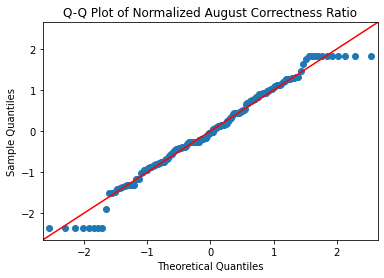

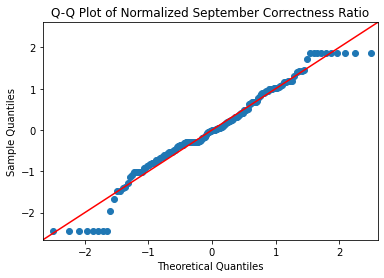

In [18]:
import statsmodels.api as sm

augCorrect = AugSeptUserSubset[AugSeptUserSubset['Month'] == 8]['IsCorrect']
septCorrect = AugSeptUserSubset[AugSeptUserSubset['Month'] == 9]['IsCorrect']
zvalsCorrAug = (augCorrect - np.mean(augCorrect))/np.std(augCorrect)
zvalsCorrSept = (septCorrect - np.mean(septCorrect))/np.std(septCorrect)

sm.qqplot(zvalsCorrAug, line='45')
plt.title('Q-Q Plot of Normalized August Correctness Ratio')
plt.savefig('QQAugCorr')
sm.qqplot(zvalsCorrSept, line='45')
plt.title('Q-Q Plot of Normalized September Correctness Ratio')
plt.savefig('QQSeptCorr')

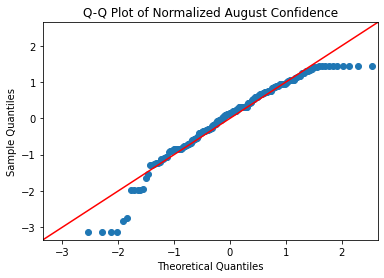

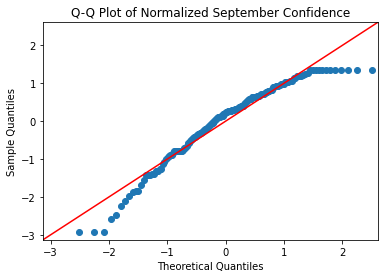

In [19]:
augConf = AugSeptUserSubset[AugSeptUserSubset['Month'] == 8]['Confidence']
septConf = AugSeptUserSubset[AugSeptUserSubset['Month'] == 9]['Confidence']
zvalsConfAug = (augConf - np.mean(augConf))/np.std(augConf)
zvalsConfSept = (septConf - np.mean(septConf))/np.std(septConf)

sm.qqplot(zvalsConfAug, line='45')
plt.title('Q-Q Plot of Normalized August Confidence')
plt.savefig('QQAugConf')

sm.qqplot(zvalsConfSept, line='45')
plt.title('Q-Q Plot of Normalized September Confidence')
plt.savefig('QQSeptConf')

In [20]:
# Further data cleaning in preparation for exended subject analysis

In [21]:
def clean_array(substrs):
    # cleans split string substrings into an array of ints
    cleaned_substr = []
    for substr in substrs:
        substr = re.sub(' ', '', substr)
        substr = re.sub('\[', '', substr)
        substr = re.sub('\]', '', substr)
        substr = re.sub(',', '', substr)
        if len(substr) == 0:
            cleaned_substr.append(1000)
        else:
            cleaned_substr.append(int(substr))
    return cleaned_substr

questiondata = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/question_metadata_task_3_4.csv.gz')
subdata = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/subject_metadata.csv.gz')

    # changes the string of subjectIds for each row in question data to an array of ints
questiondata['SubjectId'] = questiondata['SubjectId'].apply(lambda subjectlist: clean_array(subjectlist.split(',')))
    # from subject data, takes the names, parentIds and Levels of each subjectId in array for each row
questiondata['SubjectNames'] = questiondata['SubjectId'].apply(lambda subjects : [subdata[subdata['SubjectId'] == subject]['Name'] for subject in subjects])
questiondata['ParentIds'] = questiondata['SubjectId'].apply(lambda subjects : [subdata[subdata['SubjectId'] == subject]['ParentId'] for subject in subjects])
questiondata['Levels'] = questiondata['SubjectId'].apply(lambda subjects : [subdata[subdata['SubjectId'] == subject]['Level'] for subject in subjects])

mastersub = pd.merge(master, questiondata, on = 'QuestionId')
confsub = mastersub[pd.notnull(mastersub['Confidence'])]
confsub.head()
confsubgroup = confsub.groupby('QuestionId').agg('sum').reset_index()
confsubgroup['AnswersForQuestion'] = confsubgroup['IsAnswered']
# add here anything else you want to 
questionstats = confsubgroup[['QuestionId','AnswersForQuestion','IsCorrect','Confidence','Overconfidence']].merge(questiondata, how = 'left')
questionstats.drop(['SubjectNames','ParentIds','Levels'],axis = 1, inplace = True)
# question stats now has the total sum for correctness, confidence and overconfidence

# this is how you would just get level 2 stuff
#level2 = subdata[subdata.Level == 2]
level = subdata.copy()
sl = level.shape[0]
level['Count'] = [0] * sl
level['TotalConf'] = [0] * sl
level['TotalCorrect'] = [0] * sl
level = level.reset_index()

#print(level.head())

for i in range(questionstats.shape[0]):
    for levelsub in level.SubjectId.unique():
        if levelsub in questionstats['SubjectId'][i]:
            subjectIndex = level.index[level['SubjectId'] == levelsub].tolist()[0]
            level['Count'][subjectIndex] = level['Count'][subjectIndex] + questionstats['AnswersForQuestion'][i]
            level['TotalConf'][subjectIndex] = level['TotalConf'][subjectIndex] + questionstats['Confidence'][i]
            level['TotalCorrect'][subjectIndex] = level['TotalCorrect'][subjectIndex] + questionstats['IsCorrect'][i]

level['ConfRatio'] = level['TotalConf'] / level['Count']
level['CorrectRatio'] = level['TotalCorrect'] / level['Count']

level.head()

/tmp/ipykernel_101/1991636678.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level['Count'][subjectIndex] = level['Count'][subjectIndex] + questionstats['AnswersForQuestion'][i]
/tmp/ipykernel_101/1991636678.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level['TotalConf'][subjectIndex] = level['TotalConf'][subjectIndex] + questionstats['Confidence'][i]
/tmp/ipykernel_101/1991636678.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

,index,SubjectId,Name,ParentId,Level,Count,TotalConf,TotalCorrect,ConfRatio,CorrectRatio
0,0,3,Maths,NaN,0,346428,25617525,215481,73.947617,0.622008
1,1,32,Number,3.0,1,208815,15458650,133032,74.030362,0.637081
2,2,33,BIDMAS,144.0,3,22593,1694425,13767,74.997787,0.609348
3,3,34,Upper and Lower Bounds,141.0,3,0,0,0,NaN,NaN
4,4,35,Calculator Use,32.0,2,0,0,0,NaN,NaN


In [22]:
level3 = level[level['Level'] == 3]
level2 = level[level['Level'] == 2]
level1 = level[level['Level'] == 1]
level0 = level[level['Level'] == 0]

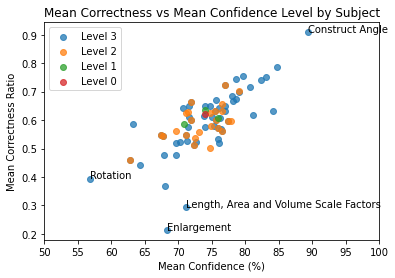

In [23]:
level3 = level[level['Level'] == 3]


outliers = level3[level3['CorrectRatio'] < 0.36]
maxCor = level3[level3['CorrectRatio'] > 0.9]
minCor = level3[level3['ConfRatio'] < 60]

fig, ax = plt.subplots()
a = plt.scatter(level3.ConfRatio, level3.CorrectRatio, alpha = 0.75, label = 'Level 3')
for outlier in [maxCor, minCor, outliers.iloc[0:1], outliers.iloc[1:2]]:
    plt.annotate(outlier['Name'].iloc[0], (outlier['ConfRatio'].iloc[0], outlier['CorrectRatio'].iloc[0]))
b = plt.scatter(level2.ConfRatio, level2.CorrectRatio, alpha = 0.75, label = 'Level 2')
c = plt.scatter(level1.ConfRatio, level1.CorrectRatio, alpha = 0.75, label = 'Level 1')
d = plt.scatter(level0.ConfRatio, level0.CorrectRatio, alpha = 0.75, label = 'Level 0')
plt.title('Mean Correctness vs Mean Confidence Level by Subject')
ax.set_xticks(np.linspace(50,100,11))
plt.xlabel('Mean Confidence (%)')
plt.ylabel('Mean Correctness Ratio')
plt.legend(loc = 'upper left')
plt.savefig('CorrConfScatter')
plt.show()


In [24]:
for outlier in [maxCor, minCor, outliers.iloc[0:1], outliers.iloc[1:2]]:
    print(outlier)

     index  SubjectId             Name  ParentId  Level  Count  TotalConf  \
135    135        190  Construct Angle      83.0      3    669      59800   

     TotalCorrect  ConfRatio  CorrectRatio  
135           608  89.387145      0.908819  
    index  SubjectId      Name  ParentId  Level  Count  TotalConf  \
60     60         93  Rotation     278.0      3   1169      66525   

    TotalCorrect  ConfRatio  CorrectRatio  
60           461  56.907613      0.394354  
    index  SubjectId         Name  ParentId  Level  Count  TotalConf  \
61     61         94  Enlargement     278.0      3    159      10875   

    TotalCorrect  ConfRatio  CorrectRatio  
61            34  68.396226      0.213836  
     index  SubjectId                                   Name  ParentId  Level  \
216    216        273  Length, Area and Volume Scale Factors     272.0      3   

     Count  TotalConf  TotalCorrect  ConfRatio  CorrectRatio  
216    363      25825           107  71.143251      0.294766  


In [25]:
level.head()

,index,SubjectId,Name,ParentId,Level,Count,TotalConf,TotalCorrect,ConfRatio,CorrectRatio
0,0,3,Maths,NaN,0,346428,25617525,215481,73.947617,0.622008
1,1,32,Number,3.0,1,208815,15458650,133032,74.030362,0.637081
2,2,33,BIDMAS,144.0,3,22593,1694425,13767,74.997787,0.609348
3,3,34,Upper and Lower Bounds,141.0,3,0,0,0,NaN,NaN
4,4,35,Calculator Use,32.0,2,0,0,0,NaN,NaN


In [26]:
level1[level1.Count > 0].value_counts()

index  SubjectId  Name                  ParentId  Level  Count   TotalConf  TotalCorrect  ConfRatio  CorrectRatio
1      32         Number                3.0       1      208815  15458650   133032        74.030362  0.637081        1
17     49         Algebra               3.0       1      57228   4056950    33604         70.890997  0.587195        1
39     71         Geometry and Measure  3.0       1      80385   6101925    48845         75.908752  0.607638        1
dtype: int64

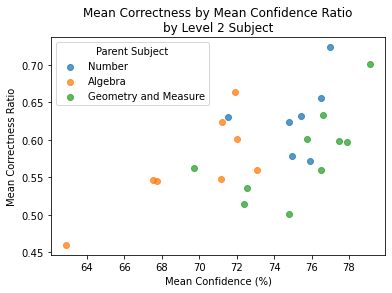

In [27]:
level2 = level[(level['Level'] == 2)&(level['Count'] > 0)]
plt.scatter(level2[level2.ParentId == 32].ConfRatio, level2[level2.ParentId == 32].CorrectRatio, alpha = 0.75, label = 'Number')
plt.scatter(level2[level2.ParentId == 49].ConfRatio, level2[level2.ParentId == 49].CorrectRatio, alpha = 0.75, label = 'Algebra')
plt.scatter(level2[level2.ParentId == 71].ConfRatio, level2[level2.ParentId == 71].CorrectRatio, alpha = 0.75, label = 'Geometry and Measure')
plt.legend(title = 'Parent Subject')
plt.title("Mean Correctness by Mean Confidence Ratio\nby Level 2 Subject")
plt.xlabel('Mean Confidence (%)')
plt.ylabel('Mean Correctness Ratio')
plt.savefig('Level2Grouped')

In [28]:
import scipy.stats as stats
stats.f_oneway(level2[level2.ParentId == 32]['ConfRatio'],
               level2[level2.ParentId == 49]['ConfRatio'],
               level2[level2.ParentId == 71]['ConfRatio'],
              )

F_onewayResult(statistic=10.404654914910186, pvalue=0.0006602813046370438)

In [29]:
level2.groupby('ParentId').agg('count')

,index,SubjectId,Name,Level,Count,TotalConf,TotalCorrect,ConfRatio,CorrectRatio
ParentId,,,,,,,,,
32.0,7,7,7,7,7,7,7,7,7
49.0,8,8,8,8,8,8,8,8,8
71.0,10,10,10,10,10,10,10,10,10


In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

level1 = {32 : 'Number', 49 : 'Algebra', 71 : 'Geometry and Measure'}
level2['ParentName'] = level2['ParentId'].apply(lambda x : level1[x])
model = ols('ConfRatio ~ ParentName', data=level2).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

/tmp/ipykernel_101/152091452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level2['ParentName'] = level2['ParentId'].apply(lambda x : level1[x])


,sum_sq,df,F,PR(>F)
ParentName,167.447665,2.0,10.404655,0.00066
Residual,177.028871,22.0,NaN,NaN


In [31]:
#### observed residual mean square = mean residual ss
orms = 177.028871/22

nN = 7
nA = 8
nGM = 10

lsdNA = scipy.stats.t.ppf(q=1-.05/2,df=22)*math.sqrt(orms*(1/nN + 1/nA))
lsdNGM = scipy.stats.t.ppf(q=1-.05/2,df=22)*math.sqrt(orms*(1/nN + 1/nGM))
lsdAGM = scipy.stats.t.ppf(q=1-.05/2,df=22)*math.sqrt(orms*(1/nA + 1/nGM))

print(lsdNA,lsdNGM, lsdAGM)

3.0446999294915305 2.899134217713764 2.7905135790643296


In [32]:
# Code for creation of "ConfidenceCategories" plot

In [33]:
# Function to be applied to rows of dataframe to fill "ConfidenceCategory" column
def confidenceCategoriser(IsCorrect, Confidence):
    if IsCorrect == 0 and Confidence >= 75:
        return "Overconfident"
    if IsCorrect == 1 and Confidence <= 25:
        return "Underconfident"
    if IsCorrect == 1 and Confidence >=75:
        return "Knowledgeable"
    if IsCorrect == 0 and Confidence <= 25:
        return "Realistic"
    else:
        return "NoInfo"

In [34]:
# Creation of "ConfidenceCategoryColumn"
mastercopy['ConfidenceCategory'] = mastercopy.apply(lambda row: confidenceCategoriser(row['IsCorrect'], row['Confidence']), axis = 1)
# Drop non categorised answers
mastercopy = mastercopy.drop(mastercopy[mastercopy["ConfidenceCategory"]=="NoInfo"].index)

In [35]:
# Split data by confidence categories
knowledgeable = mastercopy[mastercopy["ConfidenceCategory"] == 'Knowledgeable']
realistic = mastercopy[mastercopy["ConfidenceCategory"] == 'Realistic']
underconfident = mastercopy[mastercopy["ConfidenceCategory"] == 'Underconfident']
overconfident = mastercopy[mastercopy["ConfidenceCategory"] == 'Overconfident']

no_knowledgeable_females = knowledgeable[knowledgeable['Gender']==1].shape[0]
no_knowledgeable_males = knowledgeable[knowledgeable['Gender']==2].shape[0]

no_realistic_females = realistic[realistic['Gender']==1].shape[0]
no_realistic_males = realistic[realistic['Gender']==2].shape[0]

no_overconfident_females = overconfident[overconfident['Gender']==1].shape[0]
no_overconfident_males = overconfident[overconfident['Gender']==2].shape[0]

no_underconfident_females = underconfident[underconfident['Gender']==1].shape[0]
no_underconfident_males = underconfident[underconfident['Gender']==2].shape[0]

In [36]:
# Preparation of data for multivariate bar plot
dataPoints = [['Knowledgeable',no_knowledgeable_males,no_knowledgeable_females],['Overconfident',no_overconfident_males,no_overconfident_females],['Realistic',no_realistic_males,no_realistic_females],['Underconfident',no_underconfident_males,no_underconfident_females]]

In [37]:
# Creation of dataframe for multivariate bar plot
df = pd.DataFrame(dataPoints, columns = ['ConfidenceCategory', 'Male', 'Female'])
df2 = df
df2['MalePercent'] = (df['Male'] / df['Male'].sum()) * 100
df2['FemalePercent'] = (df['Female'] / df['Female'].sum()) * 100
df2 = df2.drop(columns=["Male","Female"])

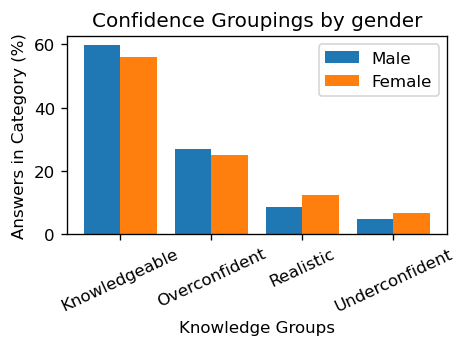

In [38]:
# Bar plot
plt.figure(figsize=(4,3), dpi=120)
plt.rcParams.update({'font.size': 10})
X = df2["ConfidenceCategory"]
X_axis = np.arange(len(X))
ax = plt.bar(X_axis - 0.2, df2["MalePercent"], 0.4, label = "Male")
ax = plt.bar(X_axis + 0.2, df2["FemalePercent"], 0.4, label = "Female")
plt.xticks(X_axis, X)
plt.xlabel("Knowledge Groups")
plt.ylabel("Answers in Category (%)")
plt.legend()
plt.xticks(rotation = 25)
plt.title("Confidence Groupings by gender")
plt.tight_layout()
plt.savefig("ConfidenceGroupingsByGender")
plt.show()

In [39]:
# Correlation coefficient calculation
data = mastercopy[mastercopy['Confidence'] >= 0].groupby(by="UserId").mean()
corrCoef1 = data["IsCorrect"]
corrCoef2 = data["Confidence"]
corrCoefficient = np.corrcoef(corrCoef1, corrCoef2)

In [40]:
pearsonCoef = corrCoefficient[0][1]
print(pearsonCoef)

0.43153848486388346
